In [50]:
# imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.animation import FuncAnimation
from scipy.linalg import eig
from ffmpeg import *
import sys

import scipy.optimize as opt;

In [ ]:
# définitions des variables physique et de simulation
nx = 20
DT = 1/nx**2/2
t_end = 2

mu = 0.5
V = 5

# Le code simulera avec diffusion si DIFF = 1 etc...
DIFF = 1
CONV = 1

# Le code créera une animation temporelle de la solution si ANIM = 1
ANIM = 1

CFL_DIFF = 2*mu*DT*(nx**2)
CFL_CONV = DT*nx*V

# Définition des vitesses limites théoriques de stabilité
Vlim1 = 2*mu*nx
Vlim2 = -1/(DT*nx)+Vlim1


In [ ]:
# Fonctions
def RHSdiff(nx,mu) :
    """Définition de la matrice RHS dans le cas diffusion pure, avec conditions aux limites de périodicité."""
    rhs =np.zeros([nx,nx])
    fac = mu*nx**2
    # Définition sans condition aux limites : une tridiagonale 
    for i in range(nx):
        for j in range(nx):
            if i==j :
                rhs[i,j] = - 2*fac
            elif j == i-1 or j==i+1 :
                rhs[i,j] = fac
    #conditions aux limites : périodicité
    rhs[0,-1] =   fac
    rhs[nx-1,0] =   fac
    return rhs
# print(RHSdiff(nx,mu))

def RHSconv(nx,V) :
    """Définition de la matrice RHS dans le cas convection pure, avec conditions aux limites de périodicité."""
    # Définition de la structure de la matrice :
    rhs = -np.identity(nx)
    for i in range(nx):
        for j in range(nx):
            if j==i+1 :
                rhs[i,j] = 1
    # Condition aux limites de périodicité
    rhs[nx-1,0]=1

    # dépendance en vitesse et maillage
    rhs= -rhs*V*nx

    return rhs
# print(RHSconv(nx,V))

def RHS(nx,mu,V,diff,conv,rhs_conv=RHSconv,rhs_diff=RHSdiff):
    """ Définition du RHS dans le cas général. Somme les RHS des cas particuliers concernés."""
    if diff and conv :
        A = (rhs_conv(nx,V) + rhs_diff(nx,mu))
    elif diff :
        A =  rhs_diff(nx,mu)
    elif conv :
        A = rhs_conv(nx,V)
    return A

def explicit(nx,dt,RHS):
    """ Etant donnéee une matrice RHS, renvoie la matrice A telle que U_n+1 = A*U_n 
    dans le cadre d'une intégration explicite."""
    Id = np.identity(nx)
    A = Id + RHS*dt
    return A

def gaussian(x, mean, std):
    return np.exp(-(x-mean)**2/(2*std**2))/np.sqrt(2*np.pi*std**2)

def initial_conditions(nx):
    """définit les conditions initiales de la simulation : une gaussienne de vitesses"""
    x = np.linspace(0, 1, nx)
    return gaussian(x,0.5,0.05)

def step(U,A) :
    """ Renvoi le vecteur des vitesses au pas de temps suivant."""
    return np.dot(A,U)

def solve(nx,mu,V, t_end, dt,diff=False,conv = True,solveur=explicit):
    """Simule l'écoulement dans les conditions données"""
    # initialisation des conditions initiales et du maillage
    # On stockera l'ensemble des pas de temps dans une matrice, chaque ligne étant un vecteur U_n
    matU = np.zeros([int(t_end//dt)+3,nx])
    matU[0] = initial_conditions(nx)

    #définition de la matrice de résolution, A
    rhs = RHS(nx,mu,V,diff,conv,rhs_conv=RHSconv,rhs_diff=RHSdiff)
    A = solveur(nx,dt,rhs)
    
    t = 0.0
    i = 0

    # simulation temporelle
    while t < t_end:

        u_new = step(matU[i],A)
        matU[i+1,:] = u_new.copy()
        t += dt
        i += 1

    return matU

def plot_solution(x, u,leg=None):
    plt.plot(x, u,label=leg)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()

def spectre(nx,dt,mu,V,plot=False,diff=True,conv=False,label = None) :
    """Trace le spectre de la matrice RHS dans le plan complexe."""
    rhs = (diff*RHSdiff(nx,mu) + conv*RHSconv(nx,V))
    
    l,v = eig(rhs)
    l=l/max(initial_conditions(nx))
    v=v/max(initial_conditions(nx))

    if plot :
        plt.plot(l.real, l.imag, 'o', markersize=6,label = label)
        plt.hlines(y=0.0, xmin=-2, xmax=2, color='k', linestyle='--')
        plt.xlabel('$\omega_r$')
        plt.ylabel('$\omega_i$')
        plt.gca().yaxis.label.set(rotation='horizontal', ha='right');
        plt.title('Spectrum')
    return l,v

def spectreStab(nx,dt,cfl,diff=True,conv=False):
    """Trace le spectre de la matrice rhs ainsi que la zone de stabilité de l'intégrateur temporel."""
    dtref = 1/nx/mu
    
    B = (diff*RHSdiff(nx,mu) + conv*RHSconv(nx,V))
    val, vec = eig(B)
    
    # display 
    plt.scatter(val.real, val.imag)
    dt = cfl*dtref
    x = np.r_[-4:.25:30j]/dtref
    y = np.r_[-3:3:60j]/dtref
    X, Y = np.meshgrid(x, y)
    vp = X+Y*1j
    plt.contour(X,Y,abs(integrator(dt*vp)), levels=[1], linewidths=3, colors='darkorange') # contour() accepts complex values
    plt.axis('equal')
    plt.xlabel('$\omega_r$')
    plt.ylabel('$\omega_i$')
    plt.show()
    return None

def integrator(dt):
    """ fonction d'intégration d'ordre 1 utilisable pour le tracé du spectre"""
    return 1.+ dt 

def findLim() :
    """ Cherche la première valeur de nx pour laquelle la solution diverge."""
    k = np.linspace(0,500)
    y = [0.5]
    nx = 10
    while max(y)<=1 :
        nx = int(nx*1.1)
        y = np.abs(1 - CONV * V*DT*nx*( np.exp(1j * k/nx) - 1) - DIFF * 2*mu*DT*nx**2*np.sin(k/nx/2)**2)
    plt.plot(k,y)
    plt.show()
    print(nx)

def anim(matSol) :
    """Crée une animation de la solution donnée en format GIF."""
    x = np.linspace(0,1,nx)
    fig = plt.figure() # initialise la figure
    line, = plt.plot([], []) 
    plt.xlim(0, 1)
    plt.ylim(-1, max(matSol[0]*1.1))

    def animate(i): 
        y = matSol[i]
        line.set_data(x, y)
        return line,
    
    ani = FuncAnimation(fig, animate, frames=len(matSol),
                                interval=10, blit=True, repeat=False)
    ani.save('animation.gif',fps=15)
    plt.show()

Avant de lancer une simulation, on vérifie que celle ci sera stable en théorie :

V - 2mu/dx < 0           False
dt/dx*(V-2.mu/dx) > -1   True


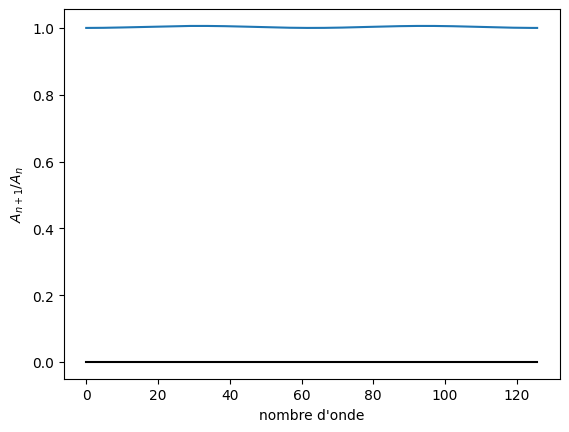

A_{n+1}/A_{n} =  1.0059999852888317
simulation numérique instable


SystemExit: 

C:\Users\vbarr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [63]:
# critère de stabilité
k = np.linspace(0,4*np.pi*nx,1000)

if DIFF and CONV :
    critere1 = V-2*mu*nx < 0
    critere2 = DT*nx*(V-2*mu*nx) > -1
    print('V - 2mu/dx < 0          ', critere1 )
    print('dt/dx*(V-2.mu/dx) > -1  ',critere2)
   
    
elif DIFF and 2*mu*DT*nx**2 < 1 :
    print('simulation stable')

elif CONV :
    print('simulation instable')

y = np.abs(1 - CONV * V*DT*nx*( np.exp(1j * k/nx) - 1) - DIFF * 4*mu*DT*nx**2*np.sin(k/nx/2)**2)

plt.plot(k,np.zeros(len(k)),'k-')
plt.plot(k,y)
plt.ylabel('$A_{n+1} / A_{n} $')
plt.xlabel("nombre d'onde")
plt.show()
print('A_{n+1}/A_{n} = ',max(y))

if max(y)>1 :
        print('simulation numérique instable')
        sys.exit()


Text(0.5, 1.0, 'mu=50  V=5  dt=0.000  dx=0.1')

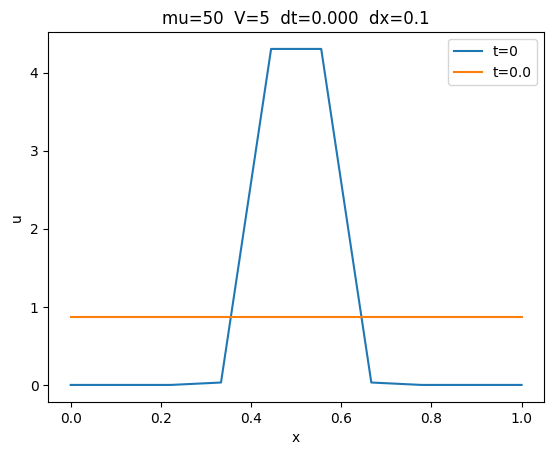

In [54]:
# résolution
matSol = solve(nx, mu,V, t_end, DT,DIFF,CONV)
x = np.linspace(0,1,nx)
t2 = int(t_end//DT - 5)
plot_solution(x,matSol[0],'t=0')
plot_solution(x,matSol[t2],'t='+str(t2*DT)[:3])
plt.title('mu='+str(mu)[:5]+'  V='+str(V)[:3]+'  dt='+str(DT)[:5]+'  dx='+str(1/nx)[:5])



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


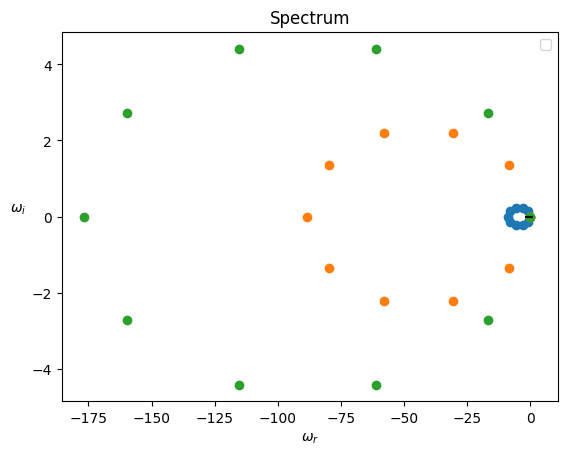

In [55]:
#analyse du spectre dans un cas diffuion pure ou convection pure
for CFL in [0.1,1,2] :
    spectre(nx,DT,CFL,CFL,True,DIFF,CONV)
    # plt.xlim([0.95,1.05])
plt.legend()
plt.show()

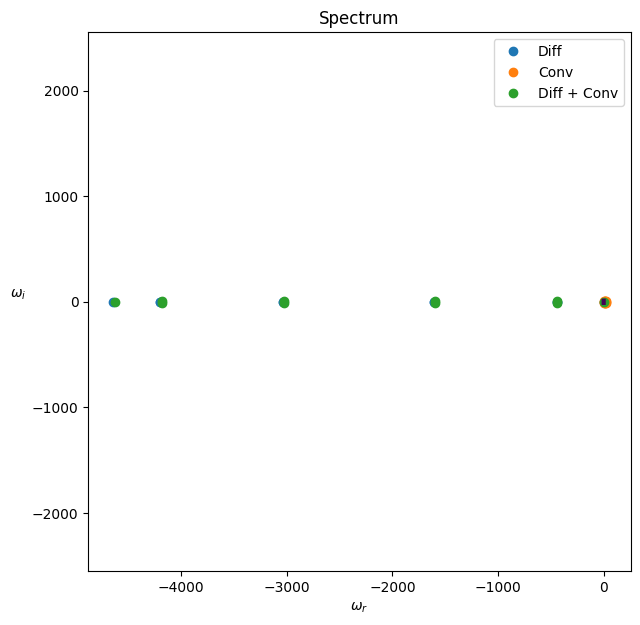

In [56]:
# tracé du spectre étudié
CFLdiff = 2*mu*DT*nx**2
CFLconv = DT*nx*V

plt.figure(figsize=[7,7])

spectre(nx,DT,mu,V,DIFF,1,0,label='Diff')
spectre(nx,DT,0,V,CONV,0,1,label='Conv')
l,v  = spectre(nx,DT,mu,V,True*DIFF*CONV,1,1,label='Diff + Conv')
# plt.xlim([0.95,1.05])
def integrator1(dt):
    return 1.+ dt 

dtref = 1/0.1/nx 

x = np.r_[-40:.25:60j]/dtref
y = np.r_[-30:30:120j]/dtref
X, Y = np.meshgrid(x, y)
vp = X+Y*1j
plt.contour(X,Y,abs(integrator1(DT*vp)), levels=[1], linewidths=3) # contour() accepts complex values

plt.axis('equal')

# ymax = 1.1*np.max(l.imag)
# ymax=4

# plt.xlim(-ymax,ymax)
# plt.ylim(-ymax,ymax)
plt.legend()
plt.show()


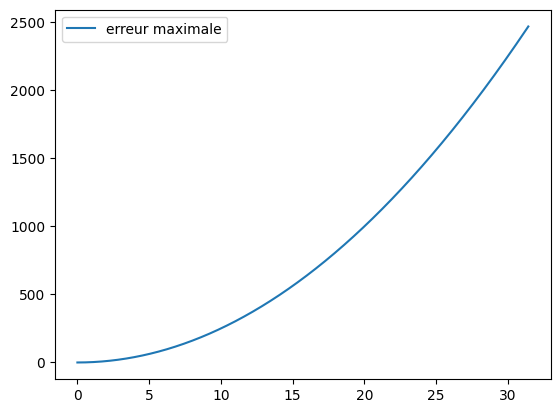

In [57]:
#estimation de l'erreur
N=30
y=np.zeros(N)
CFLs = np.linspace(0.01,5,N)
k = np.linspace(0,np.pi*nx,1000)
k2 = k**2
y = mu*k2/nx/2
plt.plot(k,y,label='erreur maximale')
plt.legend()
plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


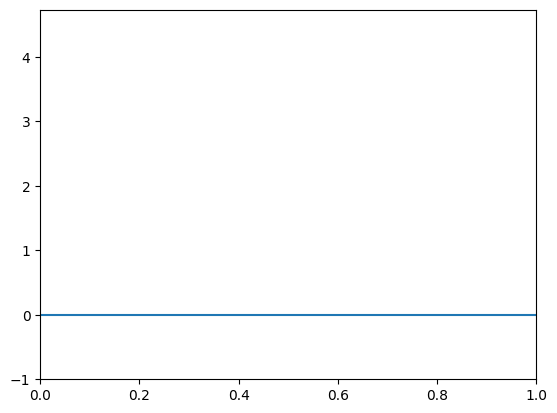

In [58]:
#animate solution
if ANIM :
    anim(matSol)

1000
1000.0


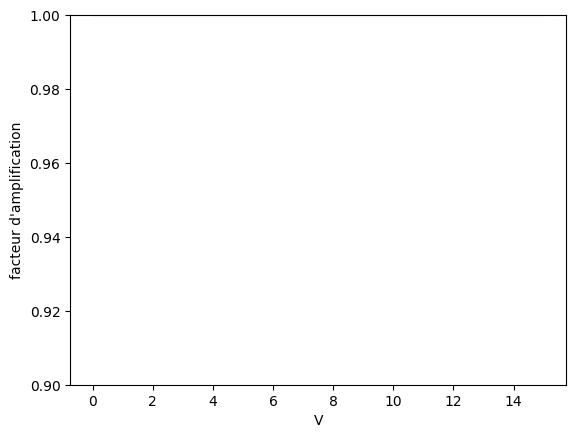

In [59]:
# max amplification = f(V)

print(2*mu*nx)
print(1/DT/nx)
Vs = np.linspace(0,15,100)
k = np.linspace(0,4*np.pi*nx,1000)
y = np.zeros(100)
for i in range(100):
    y[i] = np.max(np.abs(1 - CONV * Vs[i]*DT*nx*( np.exp(1j * k/nx) - 1) - DIFF * 4*mu*DT*nx**2*np.sin(k/nx/2)**2))


fig,ax = plt.subplots()

ax.plot(Vs,y)
Vlim1 = 2*mu*nx
Vlim2 = -1/(DT*nx)+Vlim1
ax.fill_between(Vs, 0, 1, where=Vs<Vlim2 ,
                 color='red', alpha=0.3, transform=ax.get_xaxis_transform())
ax.fill_between(Vs, 0, 1, where=Vs>Vlim1 ,
                 color='red', alpha=0.3, transform=ax.get_xaxis_transform())
plt.ylim([0.9,max(y)])
plt.ylabel("facteur d'amplification" )
plt.xlabel("V")
plt.show()

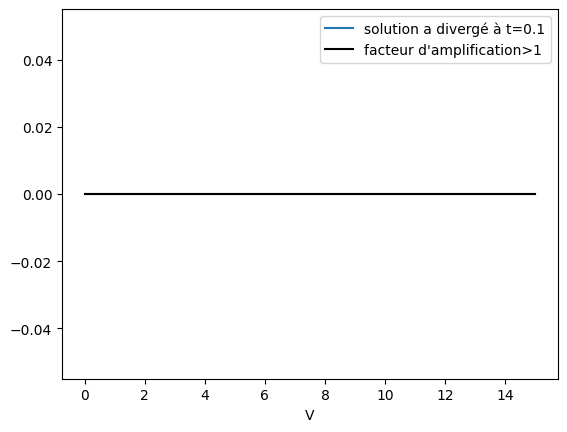

In [60]:
#stabilité en fonction de V
N = 100
Vs = np.linspace(0,15,N)
k = np.linspace(0,4*np.pi*nx,1000)
y = np.zeros(N)
stab= np.zeros(N)
for i in range(N):
    y[i] = np.max(np.abs(1 - CONV * Vs[i]*DT*nx*( np.exp(1j * k/nx) - 1) - DIFF * 4*mu*DT*nx**2*np.sin(k/nx/2)**2))>1
    matSol = solve(nx,mu,Vs[i],t_end,DT,DIFF,CONV)
    m = np.max(matSol)
    if m>8 : 
        stab[i] = 1


fig,ax = plt.subplots()
ax.plot(Vs,stab, label= 'solution a divergé à t='+str(t_end))
ax.plot(Vs,y,'k',label="facteur d'amplification>1")
ax.fill_between(Vs, 0, 1, where=Vs<Vlim2 ,
                 color='red', alpha=0.3, transform=ax.get_xaxis_transform())
ax.fill_between(Vs, 0, 1, where=Vs>Vlim1 ,
                 color='red', alpha=0.3, transform=ax.get_xaxis_transform())
# plt.plot([Vlim1,Vlim1],[0,1],'r')
# plt.plot([Vlim2,Vlim2],[0,1],'r')
# plt.title('stabilité en fonction de V')
plt.xlabel("V")

plt.legend()
plt.show()

#Stabilité en fonction de DT
# timesteps = np.linspace(1e-4,1e-2,100)

# y = np.zeros(100)
# stab= np.zeros(100)
# for i in range(100):
#     matSol = solve(nx,mu,V,t_end,timesteps[i],DIFF,CONV)
#     m = np.max(matSol)
#     if m>8 : 
#         stab[i] = 1
# plt.plot(timesteps,stab)
# plt.plot(timesteps,y)
# plt.title('Stabilité en fonction de DT')
# plt.show()

In [61]:
# Je cherche ensuite à trouver un lien entre le facteur d'amplification et la durée avant divergence flagrante
while ampli()

Vs = np.linspace(7.15,8,100)
k = np.linspace(0,4*np.pi*nx,1000)
Amp = np.zeros(100)
times = np.zeros(100)


for i in range(100):
    matSol = solve(nx,mu,Vs[i],t_end,DT,DIFF,CONV)
    m = np.max(matSol)
    # je cherche la ligne à laquelle une valeur dépasse la valeur initiale maximale
    peaks = np.where(matSol>8)
    if len(peaks[0])>0 :
        times[i] = peaks[0][0]

times = times *DT
  
for i in range(100):
    Amp[i] = np.max(np.abs(1 - CONV * Vs[i]*DT*nx*( np.exp(1j * k/nx) - 1) - DIFF * 4*mu*DT*nx**2*np.sin(k/nx/2)**2))
print(times)
plt.plot(Amp,times)
plt.show()


SyntaxError: expected ':' (3605058696.py, line 2)

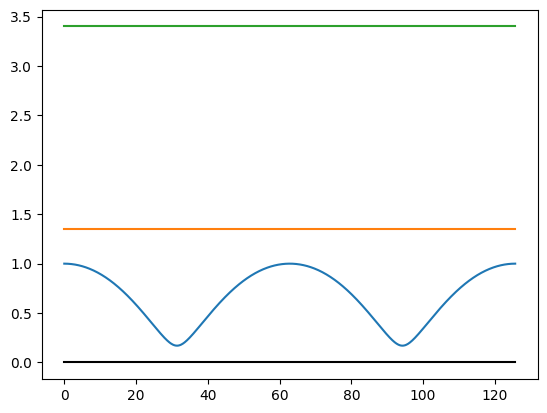

A_{n+1}/A_{n} =  1.0


In [14]:
# vérification calcul critère 2

k = np.linspace(0,4*np.pi*nx,1000)
# if DIFF and CONV and     V<mu*nx and DT*nx*(mu*nx-V)<1:
#     print('simulation stable')

ymax = 1 + 2*mu*DT*nx**2 + DT*nx*2*mu*nx
ymin = 1 + 2*mu*DT*nx**2 - DT*nx*np.sqrt(2*V**2-4*mu*V*nx+4*(mu*nx)**2)
    

y = np.abs(1 - CONV * V*DT*nx*( np.exp(1j * k/nx) - 1) - DIFF * 4*mu*DT*nx**2*np.sin(k/nx/2)**2)

plt.plot(k,np.zeros(len(k)),'k-')
plt.plot(k,y)
plt.plot([k[0],k[-1]],[ymin,ymin])
plt.plot([k[0],k[-1]],[ymax,ymax])
plt.show()
print('A_{n+1}/A_{n} = ',max(y))